In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Cell 1: Setup and Data Preparation

In [2]:

# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import os
import seaborn as sns

os.getcwd()

'/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook'

In [3]:

# ============================================================================
# DATA PREPARATION
# ============================================================================

df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Full cheater=2, Partial cheater=1

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)  # algorithm is in {game-behavior-analytics/cheating_analysis/cheating_analyzer.py}
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2  # average of task satisfaction and task engagement
df["performance"] = df["performance_score_including_cheated_words"]  # performance includes legitimate + cheated words

# Drop rows with missing key outcome or predictor variables
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])


# Prepare data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

# We use this naming convention:
# Intervention (1=concept-based message shown; 0=control) → Concept (15 concepts from 4 theories) → Motivational Message (3 variations per concept)

concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_codes = df['motivational_message_id'].astype('category').cat.codes.values

# Extract outcome and predictor arrays
y_cheating_behavior = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values
is_partialCheater, is_fullCheater = (y_cheating_behavior == 1).astype(int), (y_cheating_behavior == 2).astype(int)

# Standard deviations
perf_std, exp_std = np.std(y_performance), np.std(y_experience)

# ============================================================================
# CONTROL BASELINES CALCULATION
# ============================================================================

control_cheating = control_data['cheating_behavior'].mean()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()

# ============================================================================
# CHEATING DISTRIBUTION IN INTERVENTION GROUPS
# ============================================================================
cheating_distribution = df.groupby('concept')['cheating_behavior'].value_counts().unstack(fill_value=0)
cheating_distribution = cheating_distribution.reindex(['control'] + [c for c in concepts if c != 'control'], fill_value=0)
cheating_distribution.index.name = 'Concept'
cheating_distribution.columns = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
cheating_distribution = cheating_distribution.reset_index()
cheating_distribution.loc['Total'] = cheating_distribution.sum()
cheating_distribution.loc['Total', 'Concept'] = 'Total'

print("Cheating distribution in intervention groups:")
print(cheating_distribution)


Cheating distribution in intervention groups:
                              Concept  Non-Cheater  Partial Cheater  \
0                             control           39               10   
1                            autonomy           50               15   
2             cognitive_inconsistency           51               15   
3                          competence           51               10   
4                   descriptive_norms           51               17   
5                  dissonance_arousal           49                9   
6                dissonance_reduction           48               18   
7                   emotional_arousal           44               14   
8                    injunctive_norms           47               12   
9         performance_accomplishments           44               16   
10     reference_group_identification           55                9   
11                        relatedness           50               10   
12                       self_c

### Explorative Analysis: 1) Visualization of potential source of cheaters in intervention groups from control's performance distribution

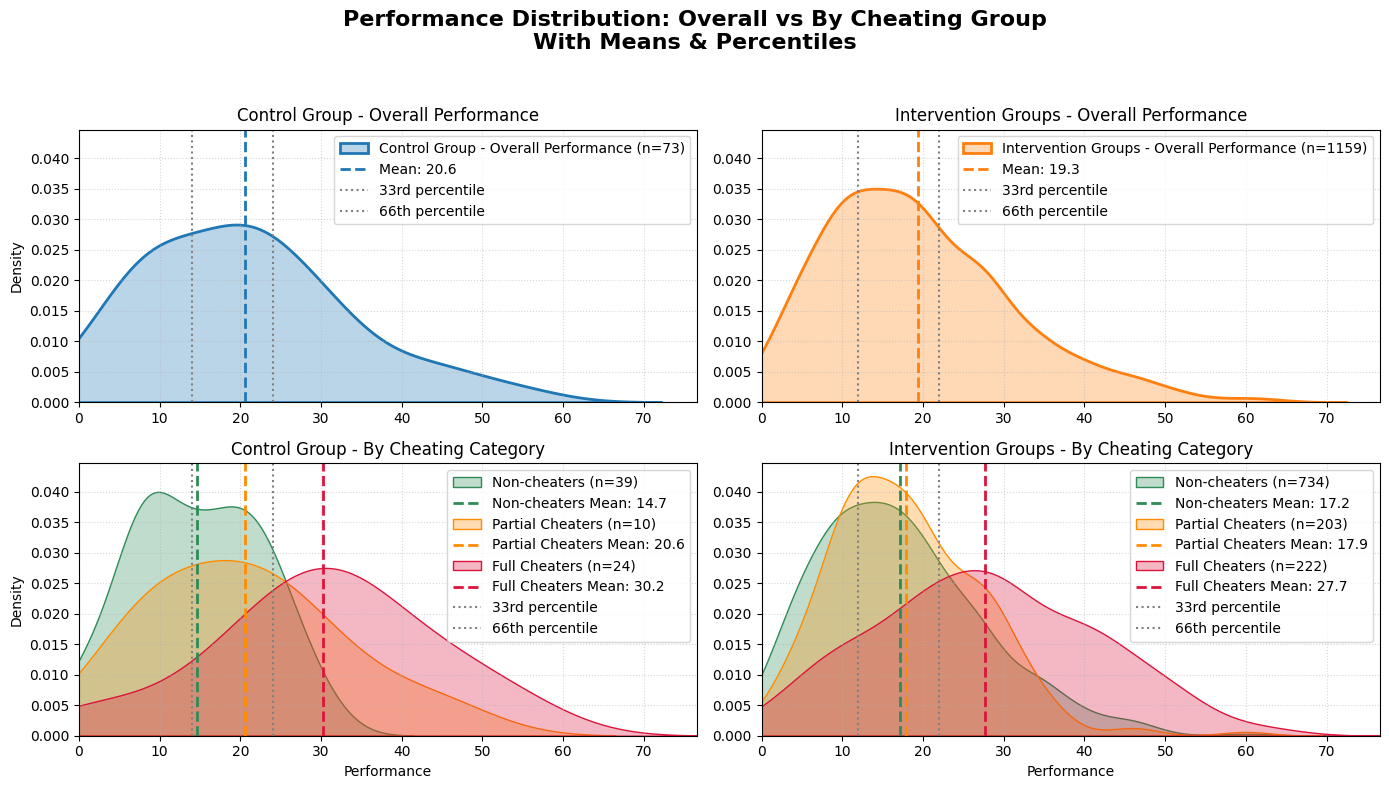


PERFORMANCE SUMMARY TABLE:
          Group          Cheating    N       Mean        Std  Min  Max
0       Control      Non-cheaters   39  14.666667   7.911794    0   30
1       Control  Partial Cheaters   10  20.600000  11.852801    6   44
2       Control     Full Cheaters   24  30.250000  13.847775    0   56
3  Intervention      Non-cheaters  734  17.193460  10.370130    0   62
4  Intervention  Partial Cheaters  203  17.940887   9.182228    0   60
5  Intervention     Full Cheaters  222  27.729730  13.730401    0   64

DISTRIBUTION OF PERFORMANCE TYPES OVER CHEATING GROUPS IN CONTROL AND INTERVENTIONS, AND CHANGE IN EXPERIENCE
PERFORMANCE SCORE CATEGORIES (based on control group percentiles)
1. Low performance: scores at or below the 33rd percentile of control group (≤ 14.0); 
2. Medium performance: scores between the 33rd and 67th percentiles of control group (14.0 – 24.0)
3. High performance: scores above the 67th percentile of control group (> 24.0)

PERFORMANCE IN CONTROL:
       

In [24]:
# =======================================================================================
# PERFORMANCE DISTRIBUTIONS FOR CONTROL vs INTERVENTION GROUPS
# =======================================================================================

# Define labels and colors
cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
colors = ['#2E8B57', '#FF8C00', '#DC143C']


# Function to plot overall performance with mean + 33rd,66th percentiles
def plot_overall(ax, data, title, color):
    subset = data['performance'].dropna()
    subset = subset[subset >= 0]
    if len(subset) < 3:
        return
    
    sns.kdeplot(subset, ax=ax, fill=True, alpha=0.3, color=color, linewidth=2, label=f"{title} (n={len(subset)})")
    
    # Mean line
    mean_val = subset.mean()
    ax.axvline(mean_val, color=color, linestyle='--', linewidth=2, label=f"Mean: {mean_val:.1f}")
    
    # 33rd and 66th percentile lines
    p33, p66 = np.percentile(subset, [33,66])
    ax.axvline(p33, color='gray', linestyle=':', linewidth=1.5, label='33rd percentile')
    ax.axvline(p66, color='gray', linestyle=':', linewidth=1.5, label='66th percentile')
    
    ax.set_title(title)
    ax.set_xlabel('Performance')
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# Function to plot performance by cheating category with individual means
def plot_by_cheating(ax, data, title):
    for i, cheat_cat in enumerate([0,1,2]):
        subset = data[data['cheating_behavior'] == cheat_cat]['performance'].dropna()
        subset = subset[subset >= 0]
        if len(subset) > 3:
            sns.kdeplot(subset, ax=ax, label=f"{cheating_labels[cheat_cat]} (n={len(subset)})", fill=True, alpha=0.3, color=colors[i])
            
            # Mean line per cheating group
            mean_val = subset.mean()
            ax.axvline(mean_val, color=colors[i], linestyle='--', linewidth=2, label=f"{cheating_labels[cheat_cat]} Mean: {mean_val:.1f}")
    
    # Overall percentiles
    overall_subset = data['performance'].dropna()
    overall_subset = overall_subset[overall_subset >= 0]
    if len(overall_subset) >= 3:
        p33, p66 = np.percentile(overall_subset, [33,66])
        ax.axvline(p33, color='gray', linestyle=':', linewidth=1.5, label='33rd percentile')
        ax.axvline(p66, color='gray', linestyle=':', linewidth=1.5, label='66th percentile')
    
    ax.set_title(title)
    ax.set_xlabel('Performance')
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# =======================================================================================
# PLOTTING IN 2x2 GRID
# =======================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle('Performance Distribution: Overall vs By Cheating Group\nWith Means & Percentiles', fontsize=16, fontweight='bold')

# First row: overall distributions
plot_overall(axes[0,0], control_data, 'Control Group - Overall Performance', '#1f77b4')
plot_overall(axes[0,1], intervention_data, 'Intervention Groups - Overall Performance', '#ff7f0e')

# Second row: distributions by cheating group
plot_by_cheating(axes[1,0], control_data, 'Control Group - By Cheating Category')
plot_by_cheating(axes[1,1], intervention_data, 'Intervention Groups - By Cheating Category')

for ax in axes[0,:]:
    ax.tick_params(axis='x', which='both', labelbottom=True)
for ax in axes.flatten():
    ax.tick_params(axis='y', which='both', labelleft=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =======================================================================================
# PERFORMANCE SUMMARY TABLE
# =======================================================================================

def performance_summary_table(data, group_name):
    """Returns mean, std, min, max per cheating category"""
    rows = []
    for cheat_cat in [0,1,2]:
        subset = data[data['cheating_behavior'] == cheat_cat]['performance'].dropna()
        subset = subset[subset >= 0]
        if len(subset) > 0:
            rows.append({
                'Group': group_name,
                'Cheating': cheating_labels[cheat_cat],
                'N': len(subset),
                'Mean': subset.mean(),
                'Std': subset.std(),
                'Min': subset.min(),
                'Max': subset.max()
            })
    return pd.DataFrame(rows)

# Combine summaries for control and interventions
control_summary = performance_summary_table(control_data, 'Control')
intervention_summary = performance_summary_table(intervention_data, 'Intervention')
summary_df = pd.concat([control_summary, intervention_summary], ignore_index=True)

print("\nPERFORMANCE SUMMARY TABLE:")
print(summary_df)

# =======================================================================================
# PERFORMANCE ANALYSIS TABLE
# =======================================================================================

# Define control performance percentiles
control_performance = df[df['concept'] == 'control']['performance'].dropna()
control_performance = control_performance[control_performance >= 0]
p33, p67 = np.percentile(control_performance, [33, 67])

print("\n" + "="*100)
print("DISTRIBUTION OF PERFORMANCE TYPES OVER CHEATING GROUPS IN CONTROL AND INTERVENTIONS, AND CHANGE IN EXPERIENCE")
print("="*100)
print("PERFORMANCE SCORE CATEGORIES (based on control group percentiles)")
print(f"1. Low performance: scores at or below the 33rd percentile of control group (≤ {p33:.1f}); ")
print(f"2. Medium performance: scores between the 33rd and 67th percentiles of control group ({p33:.1f} – {p67:.1f})")
print(f"3. High performance: scores above the 67th percentile of control group (> {p67:.1f})")

# Categorise all participants based on these bins
def get_performance_category(perf):
    if perf <= p33:
        return 'Low'
    elif perf <= p67:
        return 'Medium'
    else:
        return 'High'

df['performance_category'] = df['performance'].apply(lambda x: get_performance_category(x) if x >= 0 else np.nan)

# Set ordered categorical dtype to control sorting
category_order = ['Low', 'Medium', 'High']
df['performance_category'] = pd.Categorical(df['performance_category'], categories=category_order, ordered=True)

# Now when you do crosstabs, the order will be respected
control_data = df[df['concept'] == 'control'].copy()
intervention_data = df[df['concept'] != 'control'].copy()

def make_crosstab(data, name):
    crosstab = pd.crosstab(data['performance_category'], data['cheating_behavior'], normalize='index') * 100
    crosstab.columns = ['Non-Cheater(%)', 'Partial Cheater(%)', 'Full Cheater(%)']
    print(f"\n{name}:")
    print(crosstab.round(1))
    return crosstab
print("="*100)
control_tab = make_crosstab(control_data, "PERFORMANCE IN CONTROL")
intervention_tab = make_crosstab(intervention_data, "PERFORMANCE IN INTERVENTIONS")

change = intervention_tab - control_tab
print(f"\nCHANGE (INTERVENTION - CONTROL):")
print(change.round(2))
print("="*100)

# =======================================================================================
# EXPERIENCE ANALYSIS TABLE - MEAN RATINGS BY PERFORMER TYPES × CHEATING GROUPS
# =======================================================================================

# Create crosstabs showing MEAN EXPERIENCE for each performance-cheating combination
def make_experience_mean_crosstab(data, name):
    # Group by performance category and cheating behavior, calculate mean experience
    mean_table = (
        data.groupby(['performance_category', 'cheating_behavior'], observed=True)['experience']
        .mean()
        .round(2)
        .unstack(fill_value=np.nan)
    )
    
    mean_table.columns = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    print(f"\n{name} - MEAN EXPERIENCE RATINGS:")
    print(mean_table)
    
    return mean_table

# Create tables for control and intervention groups
control_exp_mean = make_experience_mean_crosstab(control_data, "EXPERIENCE IN CONTROL")
intervention_exp_mean = make_experience_mean_crosstab(intervention_data, "EXPERIENCE IN INTERVENTIONS")

# Calculate and print the difference (Intervention - Control)
exp_mean_change = intervention_exp_mean - control_exp_mean
print(f"\nCHANGE (INTERVENTION - CONTROL):")
print(exp_mean_change.round(2))
print("="*100)


#### Interpretation of the results above:

1. High performers can have **biggest impacts by interventions**
    - In the control, ~70% of high performers were full cheaters. Under intervention, this dropped dramatically to ~40% (↓30%).
    - The non-cheater proportion among high performers nearly tripled (~18% → ~47%). That ~30% could have moved from full cheaters to non-cheaters.
    - Interpretation: 
        - The interventions substantially could reduce cheating among high performers. It suggests that high performers might have the skills to achieve high scores without cheating but chose to cheat in control.
        - Under interventions (e.g. motivational messaging), they may choose honesty over maximizing scores without sacrificing experience (ΔExperience ≈ 0).

2. Medium performers can show **smaller cheating reductions**, but can show interesting patterns:
    - Full cheaters among medium performers reduced slightly (~23% → ~15%), a -8% change.
    - Partial cheaters increased (~14% → 20%, +6%).
    - Interpretation: 
        - Some full cheaters may have downgraded to partial cheating, and a small portion could become fully honest (non-cheaters ↑~2%).
        - Experience ratings for full cheaters in this group increased by +0.55, suggesting that interventions might have been helping them to be better engaged and satisfied.

3. Low performers were already **mostly honest**
    - Both in control and intervention, ~75% were non-cheaters. Very little change in cheating behavior:
        - Full cheaters reduced by only ~2%.
        - Partial cheaters increased by ~4% (from non-cheaters or full cheaters).
    - Experience: Low performer partial cheaters experienced a 1-point drop in experience under intervention.
        - This might imply: Messaging or intervention-induced guilt or inadequacy feelings among low performers who still cheated partially.


#### Key Takeaways:
##### Our interventions may not make weaker players cheat more if they are already mostly honest. The most notable effect we could see among high performers, where cheating can drastically be reduced under interventions without harming their experience. This suggests that behavioral interventions can transform those with the greatest capacity to cheat without diminishing their task engagement or satisfaction.